In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing

import sys

In [2]:
def convertHeader(df):
    df['GEO_ID'] = df['GEO_ID'].str[9:]
    df.columns = df.iloc[0]
    df = df.drop(index=0).rename(columns = {"":"GEOID"})
    
    cols = df.columns.tolist()

    for i in range(len(cols)):
        col = cols[i].replace("!!"," ")
        cols[i] = col
    df.columns = cols
    
    return df

def countElemStudents(df):
    df_bach = df[['GEOID','Total Estimate Bachelor\'s degree or higher']].copy()
    df_bach  = df_bach.replace("-",0)
    for col in df_bach:
        if col != "GEOID":
            df_bach[col] = df_bach[col].astype('float64')
    df_bach['Total_Bach'] = df_bach.iloc[:,1:].sum(axis = 1)
    df_bach = df_bach[['GEOID','Total_Bach']].copy()

    df_total = df_total = df[['GEOID','Total Estimate Population 18 to 24 years',
                              'Total Estimate Population 25 to 34 years',
                              "Total Estimate Population 35 to 44 years",
                              "Total Estimate Population 45 to 64 years",
                              "Total Estimate Population 65 years and over"]].copy()
    for i in df_total:
        if i != "GEOID":
            df_total[i] = df_total[i].astype('float64')
    df_total['Total'] = df_total.iloc[:,1:].sum(axis = 1)
    df_total = df_total[['GEOID','Total']].copy()
    return df_bach.merge(df_total, on="GEOID")

def assignStuToSchools(tract_durham,elem_durham, eps = 0.001):
    spatialIndex = elem_durham.sindex
    elem_durham['elem_Total'] = 0
    elem_durham['bach_Total'] = 0
    for ii in tract_durham.index:
        bgeom = tract_durham.loc[ii,'geometry']
        possibleIndMatches = list(spatialIndex.intersection(bgeom.bounds))
        possibleMatches = elem_durham.iloc[possibleIndMatches]
        
        if len(possibleMatches) == 1:
            elem_durham.at[possibleIndMatches[0],'elem_Total'] += tract_durham.loc[ii,'Total']
            elem_durham.at[possibleIndMatches[0],'bach_Total'] += tract_durham.loc[ii,'Total_Bach']
        
        else:
            intersectingAreas = possibleMatches.intersection(bgeom).area
            preciseMatches = possibleMatches[intersectingAreas/bgeom.area > eps]
            
            if len(preciseMatches) == 1:
                
                ind = list(preciseMatches.index)[0]
                elem_durham.at[ind,'elem_Total'] += tract_durham.loc[ii,'Total']
                elem_durham.at[ind,'bach_Total'] += tract_durham.loc[ii,'Total_Bach']
            
            elif len(preciseMatches) > 1:
                totalOverlap = preciseMatches.intersection(bgeom).area.sum()
                
                preciseIndMatches = preciseMatches.index
                preciseMatchAreas = preciseMatches.intersection(bgeom).area
                
                for idx in preciseIndMatches:
                    overlapRatio = preciseMatchAreas.loc[idx]/totalOverlap
                    stu = overlapRatio*tract_durham.loc[ii,'Total']
                    stu2 = overlapRatio*tract_durham.loc[ii,'Total_Bach']
                    elem_durham.at[idx,'elem_Total'] += int(round(stu))
                    elem_durham.at[idx,'bach_Total'] += int(round(stu2))
                    
            else:
                print('Tract {} students have no school to go'.format(ii))
    return elem_durham

In [3]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2012.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']
elem_durham.head()

OBJECTID facilityid stateid                           name  \
0         1     102760  320319    Creekside Elementary School   
1         4      10537  320313       Easley Elementary School   
2         7     112151  320310      Eastway Elementary School   
3        10     127429  320327  Hope Valley Elementary School   
4        13     133728  320304     Bethesda Elementary School   

                                 disttype   distarea  CreationDa   Creator  \
0  Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1  Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2  Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3  Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4  Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   

     EditDate  Editor    ShortName  \
0  2019-02-21  GISDIV    Creekside   
1  2019-02-21  GISDIV       Easley   
2  2019-02-21  GISDIV      Eastway   
3  2019-02-21  GISDIV  Hope Valley   
4  2019-02-21  GISDIV     Bethesda   

                                           LearnMore    SHAPESTAre  \
0  https://www.dpsnc.net/site/default.aspx?PageTy...  6.426582e+08   
1  https://www.dpsnc.net/site/default.aspx?PageTy...  1.981912e+08   
2  https://www.dpsnc.net/site/default.aspx?PageTy...  5.783481e+07   
3  https://www.dpsnc.net/site/default.aspx?PageTy...  1.496580e+08   
4  https://www.dpsnc.net/site/default.aspx?PageTy...  7.659973e+08   

      SHAPESTLen                                           geometry  \
0  144100.674628  POLYGON ((-78.92765 35.90246, -78.92766 35.902...   
1  104799.692970  POLYGON ((-78.89536 36.06718, -78.89689 36.064...   
2   39440.763443  POLYGON ((-78.87466 36.01328, -78.87308 36.013...   
3   71598.169440  POLYGON ((-78.93051 35.97123, -78.93012 35.971...   
4  148810.119885  POLYGON ((-78.85930 35.98430, -78.85902 35.983...   

   elem_Total  bach_Total      Perc  
0       19398        1413  0.072843  
1        6216         231  0.037162  
2        5350         214  0.040000  
3       10530         836  0.079392  
4       20546         829  0.040348

In [4]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2016.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']
elem_durham

OBJECTID facilityid stateid                               name  \
0          1     102760  320319        Creekside Elementary School   
1          4      10537  320313           Easley Elementary School   
2          7     112151  320310          Eastway Elementary School   
3         10     127429  320327      Hope Valley Elementary School   
4         13     133728  320304         Bethesda Elementary School   
5         15      14339  320328   Holt Elementary Language Academy   
6         16      14881  320324       Hillandale Elementary School   
7         18       1490  320348           Mangum Elementary School   
8         21      22310  320320            Glenn Elementary School   
9         25      22950  320315       Eno Valley Elementary School   
10        27      26148  320352    Merrick-Moore Elementary School   
11        32      33118  320360        Oak Grove Elementary School   
12        34      40934  320400       Y.E. Smith Elementary School   
13        36      47425  320363        E.K. Powe Elementary School   
14        39      53893  320332      Forest View Elementary School   
15        42      55957  320339         Lakewood Elementary School   
16        43       5758  320340                Little River School   
17        45      58263  320374   C.C. Spaulding Elementary School   
18        49      63466  320344  Fayetteville St Elementary School   
19        53      74395  320372        Southwest Elementary School   
20        56      83117  320362         Parkwood Elementary School   
21        59      87952  320388     W.G. Pearson Elementary School   
22        60      89140  320376    Spring Valley Elementary School   

                                  disttype   distarea  CreationDa   Creator  \
0   Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1   Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2   Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3   Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4   Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   
5   Elementary School Base Assignment Zone   5.591389  2018-11-08  QUAYETRI   
6   Elementary School Base Assignment Zone   8.937701  2018-07-11  QUAYETRI   
7   Elementary School Base Assignment Zone  63.437868  2018-07-11  QUAYETRI   
8   Elementary School Base Assignment Zone  25.297666  2018-07-11  QUAYETRI   
9   Elementary School Base Assignment Zone  11.340106  2018-07-11  QUAYETRI   
10  Elementary School Base Assignment Zone  14.436503  2018-07-11  QUAYETRI   
11  Elementary School Base Assignment Zone  18.688793  2018-07-11  QUAYETRI   
12  Elementary School Base Assignment Zone   1.165149  2018-07-11  QUAYETRI   
13  Elementary School Base Assignment Zone   4.734793  2020-07-23    GISDIV   
14  Elementary School Base Assignment Zone   9.998637  2020-07-23    GISDIV   
15  Elementary School Base Assignment Zone   2.374437  2018-07-11  QUAYETRI   
16  Elementary School Base Assignment Zone  24.994087  2018-07-11  QUAYETRI   
17  Elementary School Base Assignment Zone   2.145288  2018-07-11  QUAYETRI   
18  Elementary School Base Assignment Zone   1.670427  2018-07-11  QUAYETRI   
19  Elementary School Base Assignment Zone   4.013148  2018-07-11  QUAYETRI   
20  Elementary School Base Assignment Zone  11.920096  2018-07-11  QUAYETRI   
21  Elementary School Base Assignment Zone   0.753805  2018-07-11  QUAYETRI   
22  Elementary School Base Assignment Zone  20.510518  2018-07-11  QUAYETRI   

      EditDate  Editor        ShortName  \
0   2019-02-21  GISDIV        Creekside   
1   2019-02-21  GISDIV           Easley   
2   2019-02-21  GISDIV          Eastway   
3   2019-02-21  GISDIV      Hope Valley   
4   2019-02-21  GISDIV         Bethesda   
5   2019-02-21  GISDIV             Holt   
6   2019-02-21  GISDIV       Hillandale   
7   2019-02-21  GISDIV           Mangum   
8   2019-02-21  GISDIV            Glenn

In [5]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2013.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)
df_elem

GEOID  Total_Bach   Total
0   37063000101       109.1  2037.0
1   37063000102       127.9  3385.0
2   37063000200       197.8  2353.0
3   37063000301       158.9  2201.0
4   37063000302       291.2  2957.0
5   37063000401       336.9  2337.0
6   37063000402       325.8  1760.0
7   37063000500       143.5  2393.0
8   37063000600       208.2  4374.0
9   37063000700       284.6  2506.0
10  37063000900        52.9  1369.0
11  37063001001        38.7  2857.0
12  37063001002        22.7  3678.0
13  37063001100        34.8  1972.0
14  37063001301        29.8   773.0
15  37063001303        74.9  3053.0
16  37063001304        38.7  1769.0
17  37063001400        37.2  1843.0
18  37063001501       164.3  2860.0
19  37063001502       112.2  5004.0
20  37063001503       200.4  1804.0
21  37063001601       143.7  4699.0
22  37063001603       175.6  4702.0
23  37063001604       241.0  5006.0
24  37063001705       165.4  3652.0
25  37063001706       287.9  3663.0
26  37063001707       227.2  5722.0
27  37063001708       125.7  3337.0
28  37063001709        83.2  4061.0
29  37063001710       133.9  3034.0
30  37063001711        96.4  3354.0
31  37063001801       100.7  5129.0
32  37063001802        60.8  4894.0
33  37063001806       129.4  3946.0
34  37063001807       126.5  6738.0
35  37063001808       204.1  4043.0
36  37063001809       199.9  4691.0
37  37063001900       178.4  2046.0
38  37063002007       269.8  4030.0
39  37063002008       355.8  2345.0
40  37063002009        66.8  3589.0
41  37063002013       239.1  3539.0
42  37063002015       223.7  3929.0
43  37063002016       191.0  4713.0
44  37063002017       348.8  5324.0
45  37063002018       295.0  7029.0
46  37063002019       365.6  4174.0
47  37063002020       359.2  4370.0
48  37063002021       295.9  3775.0
49  37063002022       295.7  3866.0
50  37063002023       270.7  2450.0
51  37063002024       350.1  4838.0
52  37063002025       254.9  4669.0
53  37063002026       173.1  4363.0
54  37063002027       255.9  6184.0
55  37063002028       255.0  4988.0
56  37063002100       118.4  7971.0
57  37063002200       291.5  1549.0
58  37063002300        27.7  1215.0
59  37063980100        26.2    65.0

In [6]:
df = pd.read_csv('PopulationTractByEducation/Education_2014.csv')
df = convertHeader(df)
df_bach = df[['GEOID','Total Estimate Bachelor\'s degree or higher']].copy()
df_bach  = df_bach.replace("-",0)
for col in df_bach:
    if col != "GEOID":
        df_bach[col] = df_bach[col].astype('float64')

In [7]:
df_bach.sort_values('GEOID')

GEOID  Total Estimate Bachelor's degree or higher  \
1   37063000101                                         0.0   
2   37063000102                                         5.8   
3   37063000200                                        42.9   
4   37063000301                                        19.6   
5   37063000302                                        39.9   
6   37063000401                                        68.6   
7   37063000402                                        37.8   
8   37063000500                                        31.9   
9   37063000600                                        28.0   
10  37063000700                                        59.5   
11  37063000900                                         3.3   
12  37063001001                                        11.3   
13  37063001002                                         0.0   
14  37063001100                                        10.9   
15  37063001301                                         7.4   
16  37063001303                                         1.9   
17  37063001304                                         0.0   
18  37063001400                                        11.2   
19  37063001501                                         0.8   
20  37063001502                                        21.9   
21  37063001503                                         0.7   
22  37063001601                                         2.1   
23  37063001603                                         9.9   
24  37063001604                                        11.7   
25  37063001705                                        18.9   
26  37063001706                                        51.6   
27  37063001707                                        10.0   
28  37063001708                                         0.0   
29  37063001709                                         7.1   
30  37063001710                                        18.6   
31  37063001711                                         2.5   
32  37063001801                                        15.0   
33  37063001802                                         2.3   
34  37063001806                                        11.4   
35  37063001807                                        16.7   
36  37063001808                                        22.7   
37  37063001809                                        22.4   
38  37063001900                                         0.0   
39  37063002007                                        20.5   
40  37063002008                                        21.3   
41  37063002009                                         0.0   
42  37063002013                                        19.0   
43  37063002015                                        47.4   
44  37063002016                                        33.2   
45  37063002017                                        43.0   
46  37063002018                                        22.8   
47  37063002019                                        81.1   
48  37063002020                                        22.4   
49  37063002021                                        28.1   
50  37063002022                                        68.2   
51  37063002023                                        47.3   
52  37063002024                                        40.7   
53  37063002025                                        38.7   
54  37063002026                                         4.0   
55  37063002027                                        50.8   
56  37063002028                                        48.2   
57  37063002100                                         0.0   
58  37063002200                                        40.2   
59  37063002300                                         9.7   
60  37063980100                                         0.0   

    Total Estimate Bachelor's degree or higher  \
1                                         33.4   
2                                         26.3   
3               

In [8]:
df = pd.read_csv('PopulationTractByEducation/Education_2015.csv')
df = convertHeader(df)
df_bach = df[['GEOID','Total Estimate Bachelor\'s degree or higher']].copy()

In [9]:
df_bach.sort_values('GEOID')

GEOID Total Estimate Bachelor's degree or higher  \
3   37063000101                                          0   
4   37063000102                                         31   
5   37063000200                                         77   
6   37063000301                                         68   
7   37063000302                                        148   
8   37063000401                                         84   
9   37063000402                                        165   
10  37063000500                                        187   
11  37063000600                                        110   
12  37063000700                                         65   
13  37063000900                                         15   
14  37063001001                                         46   
15  37063001002                                          0   
16  37063001100                                         27   
17  37063001301                                         13   
18  37063001303                                         55   
19  37063001304                                          0   
20  37063001400                                         44   
21  37063001501                                         36   
22  37063001502                                        556   
23  37063001503                                         12   
24  37063001601                                          7   
25  37063001603                                         37   
26  37063001604                                         35   
27  37063001705                                        109   
28  37063001706                                        293   
29  37063001707                                         47   
30  37063001708                                          0   
31  37063001709                                         34   
32  37063001710                                          3   
33  37063001711                                         15   
34  37063001801                                        108   
35  37063001802                                         32   
36  37063001806                                         48   
37  37063001807                                         68   
38  37063001808                                        106   
39  37063001809                                        130   
40  37063001900                                          0   
41  37063002007                                         52   
42  37063002008                                         23   
43  37063002009                                          0   
44  37063002013                                         47   
45  37063002015                                        236   
46  37063002016                                        233   
47  37063002017                                        245   
48  37063002018                                        155   
49  37063002019                                        541   
50  37063002020                                         90   
51  37063002021                                        152   
52  37063002022                                        132   
53  37063002023                                        105   
54  37063002024                                         78   
55  37063002025                                        137   
56  37063002026                                         24   
57  37063002027                                        661   
58  37063002028                                        281   
59  37063002100                                          0   
60  37063002200                                         64   
1   37063002300                                         26   
2   37063980100                                          0   

   Total Estimate Bachelor's degree or higher  \
3                                         132   
4                                         296   
5                                         337   
6                              

In [10]:
df = pd.read_csv('PopulationTractByEducation/Education_2015.csv')
df = convertHeader(df)
df_bach = df[['GEOID','Total Estimate Bachelor\'s degree or higher']].copy()
df_bach  = df_bach.replace("-",0)
for col in df_bach:
    if col != "GEOID":
        df_bach[col] = df_bach[col].astype('float64')

In [11]:
df_bach.sort_values('GEOID')

GEOID  Total Estimate Bachelor's degree or higher  \
3   37063000101                                         0.0   
4   37063000102                                        31.0   
5   37063000200                                        77.0   
6   37063000301                                        68.0   
7   37063000302                                       148.0   
8   37063000401                                        84.0   
9   37063000402                                       165.0   
10  37063000500                                       187.0   
11  37063000600                                       110.0   
12  37063000700                                        65.0   
13  37063000900                                        15.0   
14  37063001001                                        46.0   
15  37063001002                                         0.0   
16  37063001100                                        27.0   
17  37063001301                                        13.0   
18  37063001303                                        55.0   
19  37063001304                                         0.0   
20  37063001400                                        44.0   
21  37063001501                                        36.0   
22  37063001502                                       556.0   
23  37063001503                                        12.0   
24  37063001601                                         7.0   
25  37063001603                                        37.0   
26  37063001604                                        35.0   
27  37063001705                                       109.0   
28  37063001706                                       293.0   
29  37063001707                                        47.0   
30  37063001708                                         0.0   
31  37063001709                                        34.0   
32  37063001710                                         3.0   
33  37063001711                                        15.0   
34  37063001801                                       108.0   
35  37063001802                                        32.0   
36  37063001806                                        48.0   
37  37063001807                                        68.0   
38  37063001808                                       106.0   
39  37063001809                                       130.0   
40  37063001900                                         0.0   
41  37063002007                                        52.0   
42  37063002008                                        23.0   
43  37063002009                                         0.0   
44  37063002013                                        47.0   
45  37063002015                                       236.0   
46  37063002016                                       233.0   
47  37063002017                                       245.0   
48  37063002018                                       155.0   
49  37063002019                                       541.0   
50  37063002020                                        90.0   
51  37063002021                                       152.0   
52  37063002022                                       132.0   
53  37063002023                                       105.0   
54  37063002024                                        78.0   
55  37063002025                                       137.0   
56  37063002026                                        24.0   
57  37063002027                                       661.0   
58  37063002028                                       281.0   
59  37063002100                                         0.0   
60  37063002200                                        64.0   
1   37063002300                                        26.0   
2   37063980100                                         0.0   

    Total Estimate Bachelor's degree or higher  \
3                                        132.0   
4                                        296.0   
5               

In [12]:
df = pd.read_csv('PopulationTractByEducation/Education_2015.csv')
df = convertHeader(df)
df_bach = df[['GEOID','Total Estimate Bachelor\'s degree or higher']].copy()
df_bach  = df_bach.replace("-",0)
for col in df_bach:
    if col != "GEOID":
        df_bach[col] = df_bach[col].astype('float64')
df_bach['Total_Bach'] = df_bach.iloc[:,1:].sum(axis = 1)
df_bach = df_bach[['GEOID','Total_Bach']].copy()

df_total = df_total = df[['GEOID','Total Estimate Population 18 to 24 years',
                          'Total Estimate Population 25 to 34 years',
                          "Total Estimate Population 35 to 44 years",
                          "Total Estimate Population 45 to 64 years",
                          "Total Estimate Population 65 years and over"]].copy()
for i in df_total:
    if i != "GEOID":
        df_total[i] = df_total[i].astype('float64')
df_total['Total'] = df_total.iloc[:,1:].sum(axis = 1)
df_total = df_total[['GEOID','Total']].copy()
return df_bach.merge(df_total, on="GEOID")

SyntaxError: 'return' outside function (<ipython-input-12-b091969cd0b7>, line 21)

In [13]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2015.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)

In [121]:
df_elem

GEOID  Total_Bach   Total
0   37063002300        87.0  1055.0
1   37063980100         0.0     0.0
2   37063000101       466.0  2123.0
3   37063000102      1062.0  3522.0
4   37063000200       984.0  2497.0
5   37063000301       671.0  2076.0
6   37063000302      1817.0  2822.0
7   37063000401      1740.0  2332.0
8   37063000402      1404.0  1815.0
9   37063000500       934.0  2877.0
10  37063000600      2054.0  4737.0
11  37063000700      1568.0  2828.0
12  37063000900       201.0  1587.0
13  37063001001       405.0  2920.0
14  37063001002       246.0  4020.0
15  37063001100       264.0  2386.0
16  37063001301       131.0  1014.0
17  37063001303       307.0  3224.0
18  37063001304       170.0  1791.0
19  37063001400       284.0  1639.0
20  37063001501        72.0  2815.0
21  37063001502      1820.0  5261.0
22  37063001503        18.0  1593.0
23  37063001601      1568.0  4556.0
24  37063001603      1786.0  4807.0
25  37063001604      2973.0  5091.0
26  37063001705      1768.0  4025.0
27  37063001706      2259.0  3979.0
28  37063001707      3067.0  5716.0
29  37063001708      1209.0  3762.0
30  37063001709       871.0  4394.0
31  37063001710       770.0  3053.0
32  37063001711       685.0  3464.0
33  37063001801      1310.0  5645.0
34  37063001802       534.0  5028.0
35  37063001806      1229.0  4150.0
36  37063001807      2269.0  6631.0
37  37063001808      2639.0  5313.0
38  37063001809      1939.0  4680.0
39  37063001900      1169.0  2522.0
40  37063002007      2495.0  3980.0
41  37063002008      1957.0  2404.0
42  37063002009       623.0  3580.0
43  37063002013      1977.0  3694.0
44  37063002015      1935.0  4319.0
45  37063002016      1562.0  4536.0
46  37063002017      4507.0  5979.0
47  37063002018      4097.0  7028.0
48  37063002019      3001.0  4093.0
49  37063002020      3903.0  4898.0
50  37063002021      2219.0  3568.0
51  37063002022      2483.0  3745.0
52  37063002023      1490.0  2614.0
53  37063002024      3399.0  5031.0
54  37063002025      2643.0  4869.0
55  37063002026      1703.0  4809.0
56  37063002027      3359.0  7015.0
57  37063002028      3635.0  5797.0
58  37063002100      2122.0  7910.0
59  37063002200       952.0  1568.0

In [119]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2013.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']
elem_durham

OBJECTID facilityid stateid                               name  \
0          1     102760  320319        Creekside Elementary School   
1          4      10537  320313           Easley Elementary School   
2          7     112151  320310          Eastway Elementary School   
3         10     127429  320327      Hope Valley Elementary School   
4         13     133728  320304         Bethesda Elementary School   
5         15      14339  320328   Holt Elementary Language Academy   
6         16      14881  320324       Hillandale Elementary School   
7         18       1490  320348           Mangum Elementary School   
8         21      22310  320320            Glenn Elementary School   
9         25      22950  320315       Eno Valley Elementary School   
10        27      26148  320352    Merrick-Moore Elementary School   
11        32      33118  320360        Oak Grove Elementary School   
12        34      40934  320400       Y.E. Smith Elementary School   
13        36      47425  320363        E.K. Powe Elementary School   
14        39      53893  320332      Forest View Elementary School   
15        42      55957  320339         Lakewood Elementary School   
16        43       5758  320340                Little River School   
17        45      58263  320374   C.C. Spaulding Elementary School   
18        49      63466  320344  Fayetteville St Elementary School   
19        53      74395  320372        Southwest Elementary School   
20        56      83117  320362         Parkwood Elementary School   
21        59      87952  320388     W.G. Pearson Elementary School   
22        60      89140  320376    Spring Valley Elementary School   

                                  disttype   distarea  CreationDa   Creator  \
0   Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1   Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2   Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3   Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4   Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   
5   Elementary School Base Assignment Zone   5.591389  2018-11-08  QUAYETRI   
6   Elementary School Base Assignment Zone   8.937701  2018-07-11  QUAYETRI   
7   Elementary School Base Assignment Zone  63.437868  2018-07-11  QUAYETRI   
8   Elementary School Base Assignment Zone  25.297666  2018-07-11  QUAYETRI   
9   Elementary School Base Assignment Zone  11.340106  2018-07-11  QUAYETRI   
10  Elementary School Base Assignment Zone  14.436503  2018-07-11  QUAYETRI   
11  Elementary School Base Assignment Zone  18.688793  2018-07-11  QUAYETRI   
12  Elementary School Base Assignment Zone   1.165149  2018-07-11  QUAYETRI   
13  Elementary School Base Assignment Zone   4.734793  2020-07-23    GISDIV   
14  Elementary School Base Assignment Zone   9.998637  2020-07-23    GISDIV   
15  Elementary School Base Assignment Zone   2.374437  2018-07-11  QUAYETRI   
16  Elementary School Base Assignment Zone  24.994087  2018-07-11  QUAYETRI   
17  Elementary School Base Assignment Zone   2.145288  2018-07-11  QUAYETRI   
18  Elementary School Base Assignment Zone   1.670427  2018-07-11  QUAYETRI   
19  Elementary School Base Assignment Zone   4.013148  2018-07-11  QUAYETRI   
20  Elementary School Base Assignment Zone  11.920096  2018-07-11  QUAYETRI   
21  Elementary School Base Assignment Zone   0.753805  2018-07-11  QUAYETRI   
22  Elementary School Base Assignment Zone  20.510518  2018-07-11  QUAYETRI   

      EditDate  Editor        ShortName  \
0   2019-02-21  GISDIV        Creekside   
1   2019-02-21  GISDIV           Easley   
2   2019-02-21  GISDIV          Eastway   
3   2019-02-21  GISDIV      Hope Valley   
4   2019-02-21  GISDIV         Bethesda   
5   2019-02-21  GISDIV             Holt   
6   2019-02-21  GISDIV       Hillandale   
7   2019-02-21  GISDIV           Mangum   
8   2019-02-21  GISDIV            Glenn

In [117]:
tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()

df = pd.read_csv('PopulationTractByEducation/Education_2015.csv')
df = convertHeader(df)

df_elem = countElemStudents(df)
tract_durham = tract_durham.merge(df_elem, on='GEOID')
#Assign School
assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']

In [118]:
elem_durham

OBJECTID facilityid stateid                               name  \
0          1     102760  320319        Creekside Elementary School   
1          4      10537  320313           Easley Elementary School   
2          7     112151  320310          Eastway Elementary School   
3         10     127429  320327      Hope Valley Elementary School   
4         13     133728  320304         Bethesda Elementary School   
5         15      14339  320328   Holt Elementary Language Academy   
6         16      14881  320324       Hillandale Elementary School   
7         18       1490  320348           Mangum Elementary School   
8         21      22310  320320            Glenn Elementary School   
9         25      22950  320315       Eno Valley Elementary School   
10        27      26148  320352    Merrick-Moore Elementary School   
11        32      33118  320360        Oak Grove Elementary School   
12        34      40934  320400       Y.E. Smith Elementary School   
13        36      47425  320363        E.K. Powe Elementary School   
14        39      53893  320332      Forest View Elementary School   
15        42      55957  320339         Lakewood Elementary School   
16        43       5758  320340                Little River School   
17        45      58263  320374   C.C. Spaulding Elementary School   
18        49      63466  320344  Fayetteville St Elementary School   
19        53      74395  320372        Southwest Elementary School   
20        56      83117  320362         Parkwood Elementary School   
21        59      87952  320388     W.G. Pearson Elementary School   
22        60      89140  320376    Spring Valley Elementary School   

                                  disttype   distarea  CreationDa   Creator  \
0   Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1   Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2   Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3   Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4   Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   
5   Elementary School Base Assignment Zone   5.591389  2018-11-08  QUAYETRI   
6   Elementary School Base Assignment Zone   8.937701  2018-07-11  QUAYETRI   
7   Elementary School Base Assignment Zone  63.437868  2018-07-11  QUAYETRI   
8   Elementary School Base Assignment Zone  25.297666  2018-07-11  QUAYETRI   
9   Elementary School Base Assignment Zone  11.340106  2018-07-11  QUAYETRI   
10  Elementary School Base Assignment Zone  14.436503  2018-07-11  QUAYETRI   
11  Elementary School Base Assignment Zone  18.688793  2018-07-11  QUAYETRI   
12  Elementary School Base Assignment Zone   1.165149  2018-07-11  QUAYETRI   
13  Elementary School Base Assignment Zone   4.734793  2020-07-23    GISDIV   
14  Elementary School Base Assignment Zone   9.998637  2020-07-23    GISDIV   
15  Elementary School Base Assignment Zone   2.374437  2018-07-11  QUAYETRI   
16  Elementary School Base Assignment Zone  24.994087  2018-07-11  QUAYETRI   
17  Elementary School Base Assignment Zone   2.145288  2018-07-11  QUAYETRI   
18  Elementary School Base Assignment Zone   1.670427  2018-07-11  QUAYETRI   
19  Elementary School Base Assignment Zone   4.013148  2018-07-11  QUAYETRI   
20  Elementary School Base Assignment Zone  11.920096  2018-07-11  QUAYETRI   
21  Elementary School Base Assignment Zone   0.753805  2018-07-11  QUAYETRI   
22  Elementary School Base Assignment Zone  20.510518  2018-07-11  QUAYETRI   

      EditDate  Editor        ShortName  \
0   2019-02-21  GISDIV        Creekside   
1   2019-02-21  GISDIV           Easley   
2   2019-02-21  GISDIV          Eastway   
3   2019-02-21  GISDIV      Hope Valley   
4   2019-02-21  GISDIV         Bethesda   
5   2019-02-21  GISDIV             Holt   
6   2019-02-21  GISDIV       Hillandale   
7   2019-02-21  GISDIV           Mangum   
8   2019-02-21  GISDIV            Glenn

In [90]:
elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']

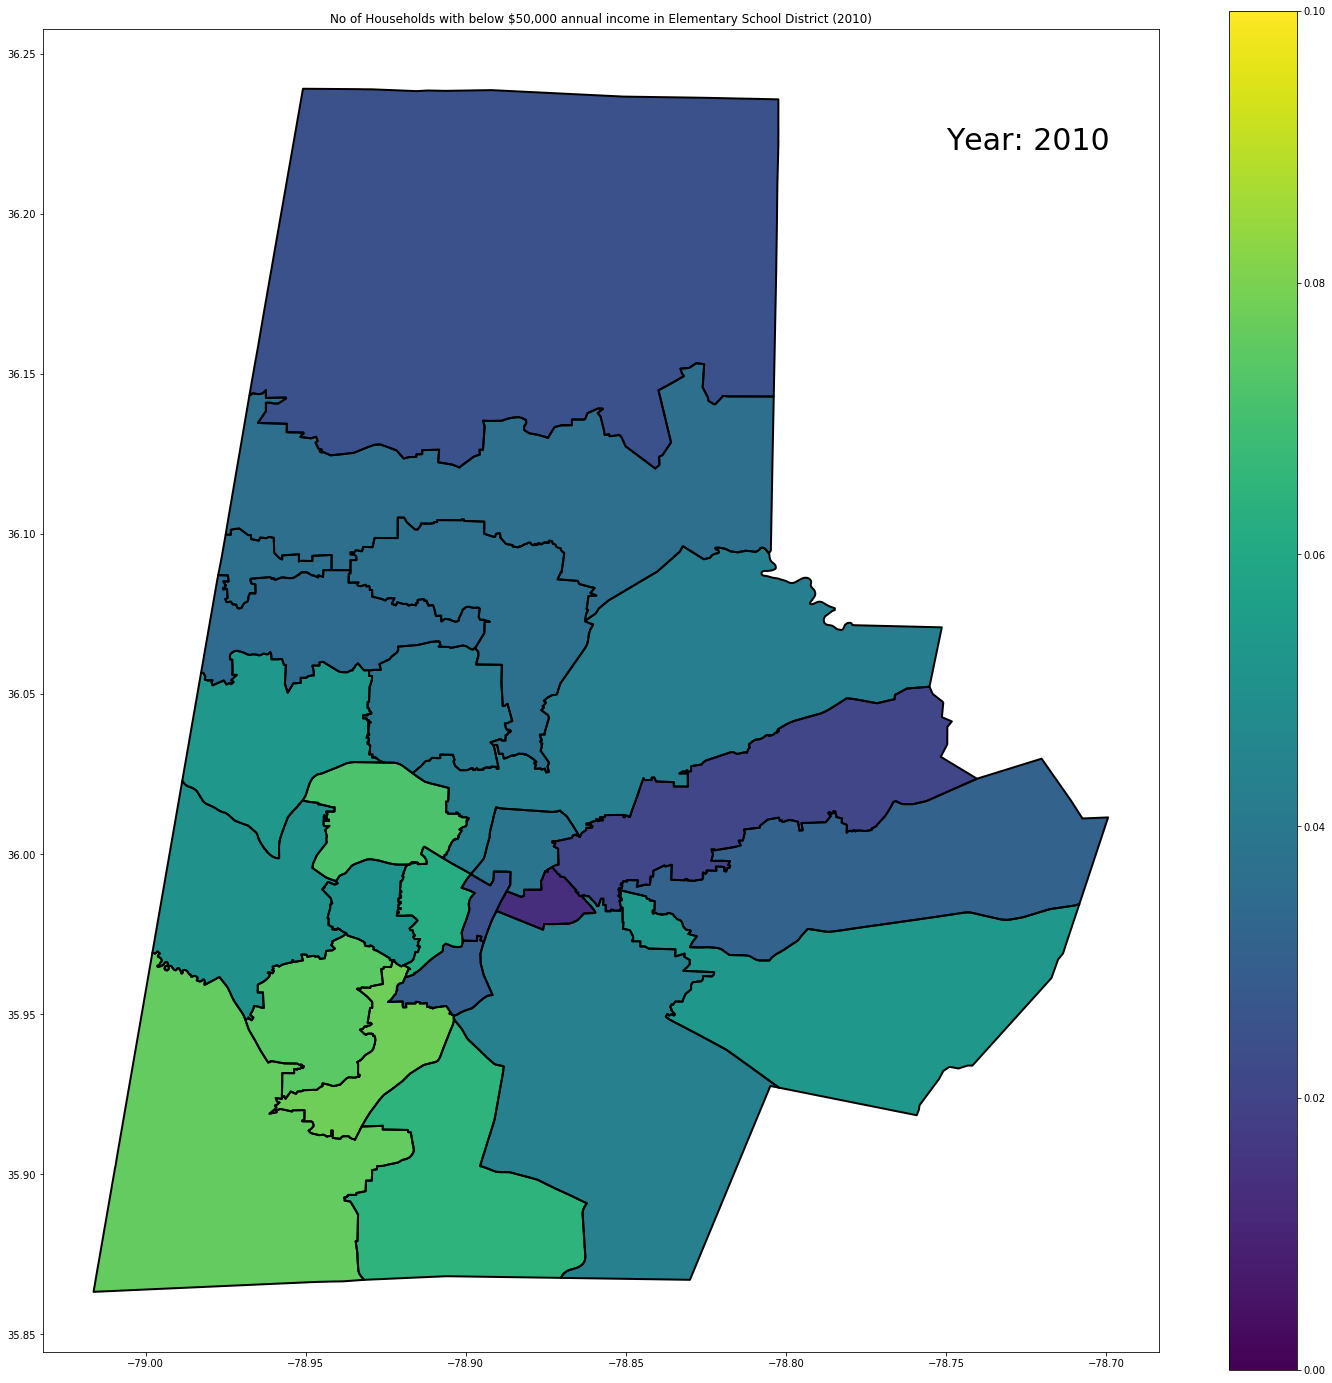

In [93]:
ig, ax = plt.subplots(1,1, figsize = (25,25))
elem_durham.plot(ax = ax, legend = True, column ='Perc', alpha = 1, vmin = 0, vmax= 0.1)
elem_durham.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax)

ax.set_title('No of Households with below $50,000 annual income in Elementary School District ({})'.format(year))
ax.text(-78.75, 36.22, 'Year: {}'.format(year), size=30)
plt.savefig('No_of_housholds_below_50000_{}.jpg'.format(year), format = 'jpg')

In [18]:
df_compiled = pd.read_csv('df_compiled.csv')

In [19]:
df_compiled

name  no_of_black_students_2010  \
0         Creekside Elementary School                        372   
1            Easley Elementary School                        165   
2           Eastway Elementary School                        412   
3       Hope Valley Elementary School                        189   
4          Bethesda Elementary School                       1123   
5    Holt Elementary Language Academy                        548   
6        Hillandale Elementary School                        185   
7            Mangum Elementary School                         28   
8             Glenn Elementary School                        791   
9        Eno Valley Elementary School                        633   
10    Merrick-Moore Elementary School                        547   
11        Oak Grove Elementary School                        292   
12       Y.E. Smith Elementary School                        205   
13        E.K. Powe Elementary School                        146   
14      Forest View Elementary School                        134   
15         Lakewood Elementary School                         84   
16                Little River School                         97   
17   C.C. Spaulding Elementary School                        200   
18  Fayetteville St Elementary School                        309   
19        Southwest Elementary School                        218   
20         Parkwood Elementary School                        445   
21     W.G. Pearson Elementary School                        179   
22    Spring Valley Elementary School                        193   

    no_of_black_students_2011  no_of_black_students_2012  \
0                         330                        306   
1                         171                        167   
2                         373                        295   
3                         171                        193   
4                        1066                       1021   
5                         462                        445   
6                         124                        134   
7                          37                         31   
8                         781                        802   
9                         767                        723   
10                        562                        446   
11                        260                        321   
12                        212                        226   
13                        143                        142   
14                        208                        274   
15                        100                        219   
16                        109                        111   
17                        196                        213   
18                        282                        303   
19                        180                        224   
20                        524                        569   
21                        165                        140   
22                        192                        191   

    no_of_black_students_2013  no_of_black_students_2014  \
0                         200                        185   
1                         160                        142   
2                         303                        276   
3                         131                        101   
4                        1204                       1371   
5                         379                        328   
6                         120                         67   
7                          88                        103   
8                         613                        556   
9                         666                        504   
10                        390                        358   
11                        387                        360   
12                        246                        285   
13                        190                        181   
14                        295                        291   

In [14]:
path_name = "PopulationTractByEducation/"
file_names = ['Education_2016.csv','Education_2015.csv','Education_2014.csv'
             ,'Education_2013.csv','Education_2012.csv','Education_2011.csv','Education_2010.csv']
file_names.reverse()

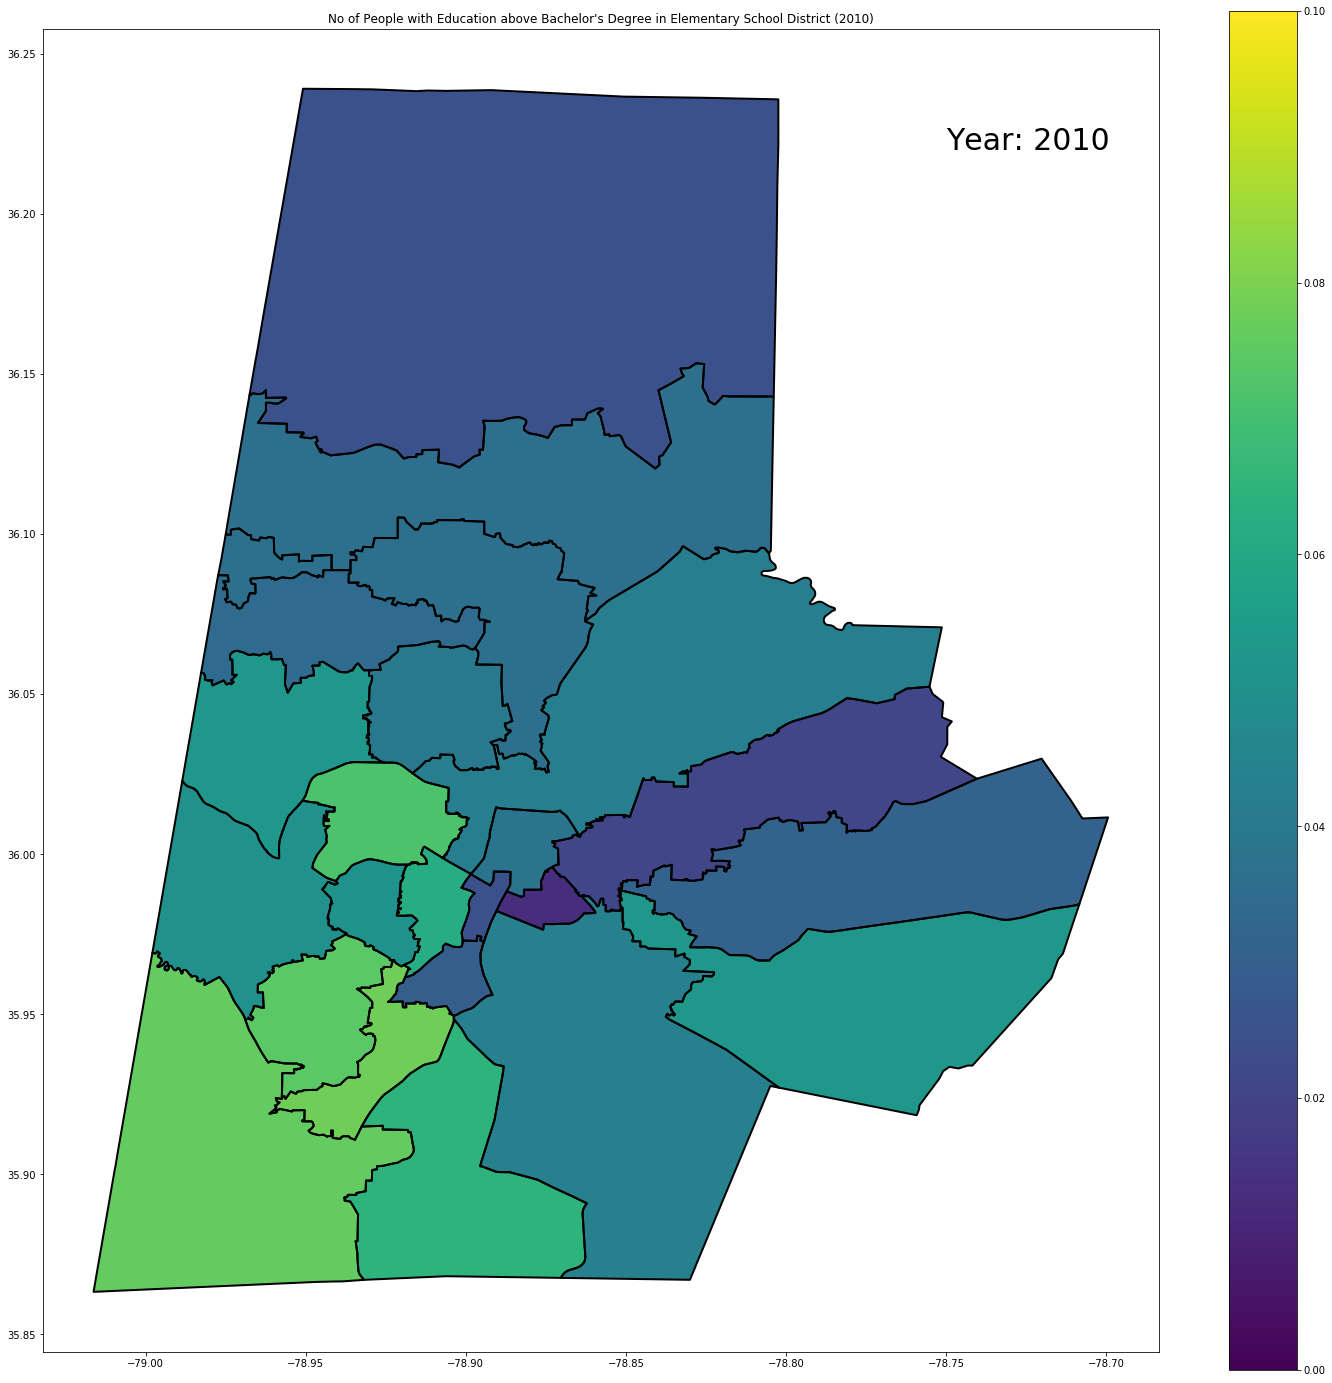

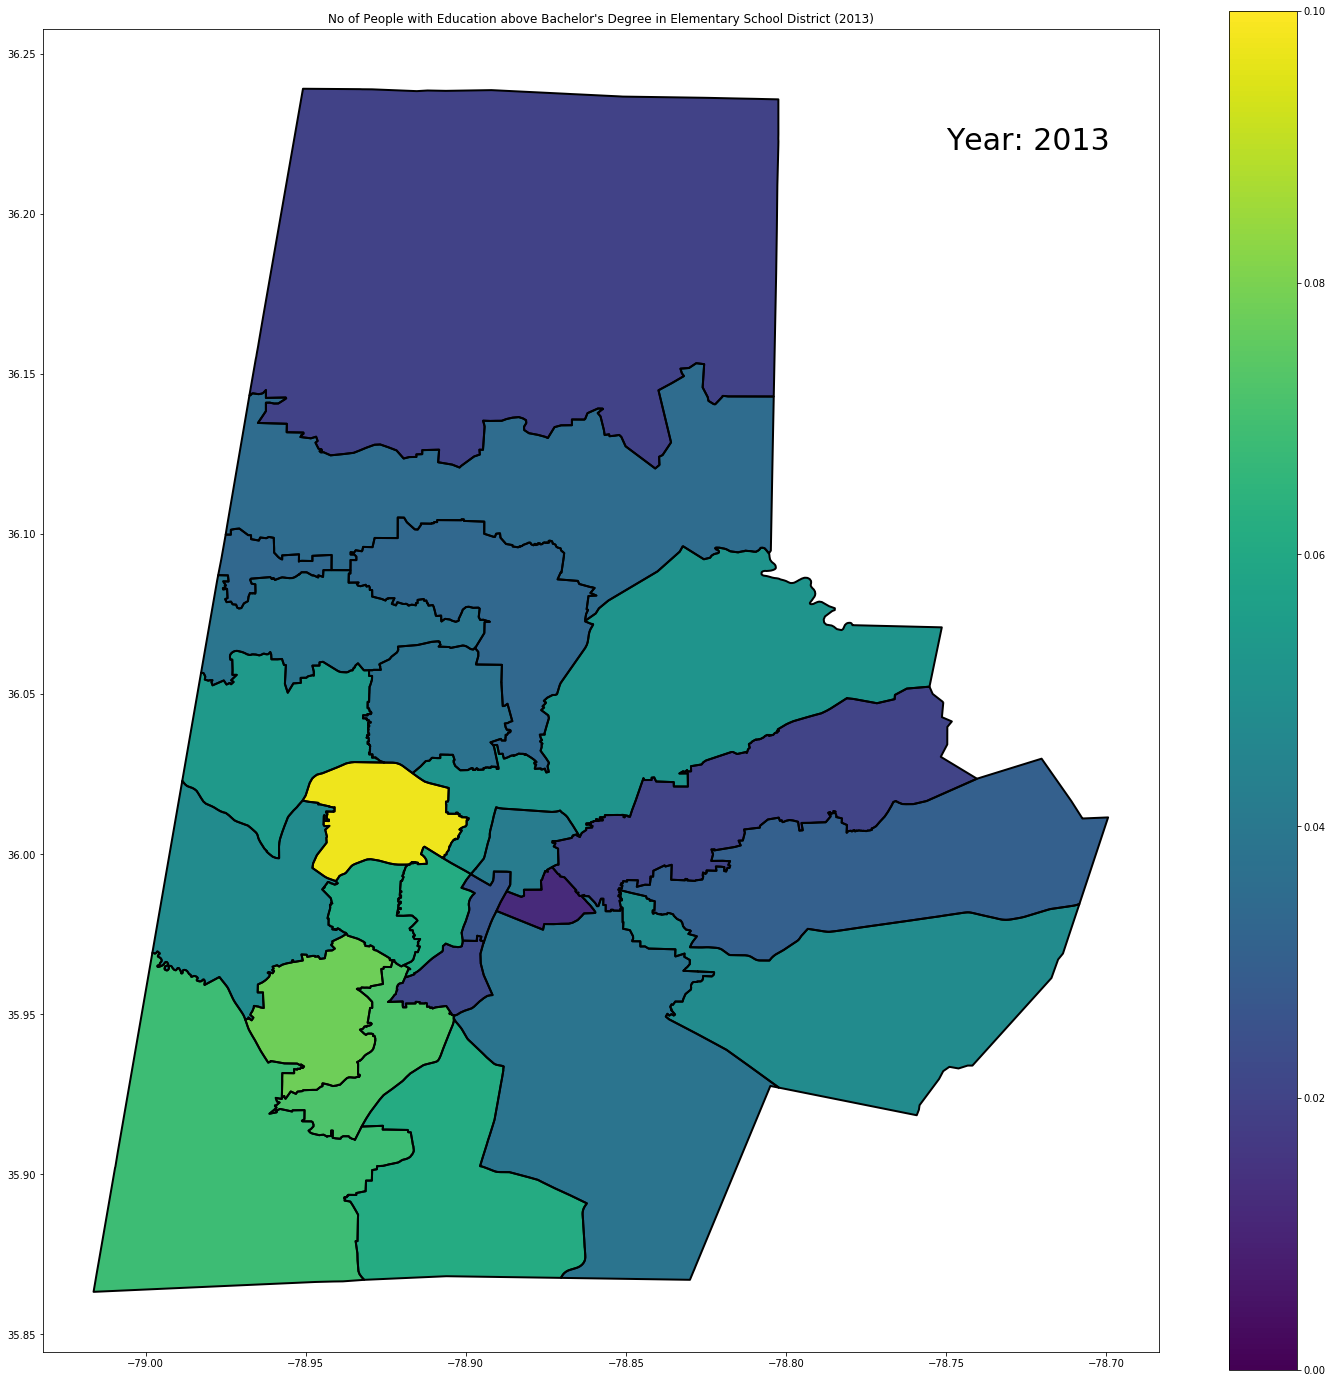

In [20]:
year = 2010
for file_name in file_names:
    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()
    
    file_path = path_name + file_name
    df = pd.read_csv(file_path)
    df = convertHeader(df)

    df_elem = countElemStudents(df)
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
    elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']
    
    ig, ax = plt.subplots(1,1, figsize = (25,25))
    elem_durham.plot(ax = ax, legend = True, column ='Perc', alpha = 1, vmin = 0, vmax= 0.1)
    elem_durham.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax)
    df_compiled['no_of_people_with_bachelors_and_above_{}'.format(year)] = elem_durham['elem_Total']
    ax.set_title('No of People with Education above Bachelor\'s Degree in Elementary School District ({})'.format(year))
    ax.text(-78.75, 36.22, 'Year: {}'.format(year), size=30)
    plt.savefig('%_people_above_bachelors_{}.jpg'.format(year), format = 'jpg')
    year +=1

In [133]:
elem_durham

OBJECTID facilityid stateid                               name  \
0          1     102760  320319        Creekside Elementary School   
1          4      10537  320313           Easley Elementary School   
2          7     112151  320310          Eastway Elementary School   
3         10     127429  320327      Hope Valley Elementary School   
4         13     133728  320304         Bethesda Elementary School   
5         15      14339  320328   Holt Elementary Language Academy   
6         16      14881  320324       Hillandale Elementary School   
7         18       1490  320348           Mangum Elementary School   
8         21      22310  320320            Glenn Elementary School   
9         25      22950  320315       Eno Valley Elementary School   
10        27      26148  320352    Merrick-Moore Elementary School   
11        32      33118  320360        Oak Grove Elementary School   
12        34      40934  320400       Y.E. Smith Elementary School   
13        36      47425  320363        E.K. Powe Elementary School   
14        39      53893  320332      Forest View Elementary School   
15        42      55957  320339         Lakewood Elementary School   
16        43       5758  320340                Little River School   
17        45      58263  320374   C.C. Spaulding Elementary School   
18        49      63466  320344  Fayetteville St Elementary School   
19        53      74395  320372        Southwest Elementary School   
20        56      83117  320362         Parkwood Elementary School   
21        59      87952  320388     W.G. Pearson Elementary School   
22        60      89140  320376    Spring Valley Elementary School   

                                  disttype   distarea  CreationDa   Creator  \
0   Elementary School Base Assignment Zone  24.173063  2018-07-11  QUAYETRI   
1   Elementary School Base Assignment Zone   7.109131  2018-11-08  QUAYETRI   
2   Elementary School Base Assignment Zone   2.074538  2018-07-11  QUAYETRI   
3   Elementary School Base Assignment Zone   5.368242  2018-07-11  QUAYETRI   
4   Elementary School Base Assignment Zone  27.476374  2018-07-11  QUAYETRI   
5   Elementary School Base Assignment Zone   5.591389  2018-11-08  QUAYETRI   
6   Elementary School Base Assignment Zone   8.937701  2018-07-11  QUAYETRI   
7   Elementary School Base Assignment Zone  63.437868  2018-07-11  QUAYETRI   
8   Elementary School Base Assignment Zone  25.297666  2018-07-11  QUAYETRI   
9   Elementary School Base Assignment Zone  11.340106  2018-07-11  QUAYETRI   
10  Elementary School Base Assignment Zone  14.436503  2018-07-11  QUAYETRI   
11  Elementary School Base Assignment Zone  18.688793  2018-07-11  QUAYETRI   
12  Elementary School Base Assignment Zone   1.165149  2018-07-11  QUAYETRI   
13  Elementary School Base Assignment Zone   4.734793  2020-07-23    GISDIV   
14  Elementary School Base Assignment Zone   9.998637  2020-07-23    GISDIV   
15  Elementary School Base Assignment Zone   2.374437  2018-07-11  QUAYETRI   
16  Elementary School Base Assignment Zone  24.994087  2018-07-11  QUAYETRI   
17  Elementary School Base Assignment Zone   2.145288  2018-07-11  QUAYETRI   
18  Elementary School Base Assignment Zone   1.670427  2018-07-11  QUAYETRI   
19  Elementary School Base Assignment Zone   4.013148  2018-07-11  QUAYETRI   
20  Elementary School Base Assignment Zone  11.920096  2018-07-11  QUAYETRI   
21  Elementary School Base Assignment Zone   0.753805  2018-07-11  QUAYETRI   
22  Elementary School Base Assignment Zone  20.510518  2018-07-11  QUAYETRI   

      EditDate  Editor        ShortName  \
0   2019-02-21  GISDIV        Creekside   
1   2019-02-21  GISDIV           Easley   
2   2019-02-21  GISDIV          Eastway   
3   2019-02-21  GISDIV      Hope Valley   
4   2019-02-21  GISDIV         Bethesda   
5   2019-02-21  GISDIV             Holt   
6   2019-02-21  GISDIV       Hillandale   
7   2019-02-21  GISDIV           Mangum   
8   2019-02-21  GISDIV            Glenn

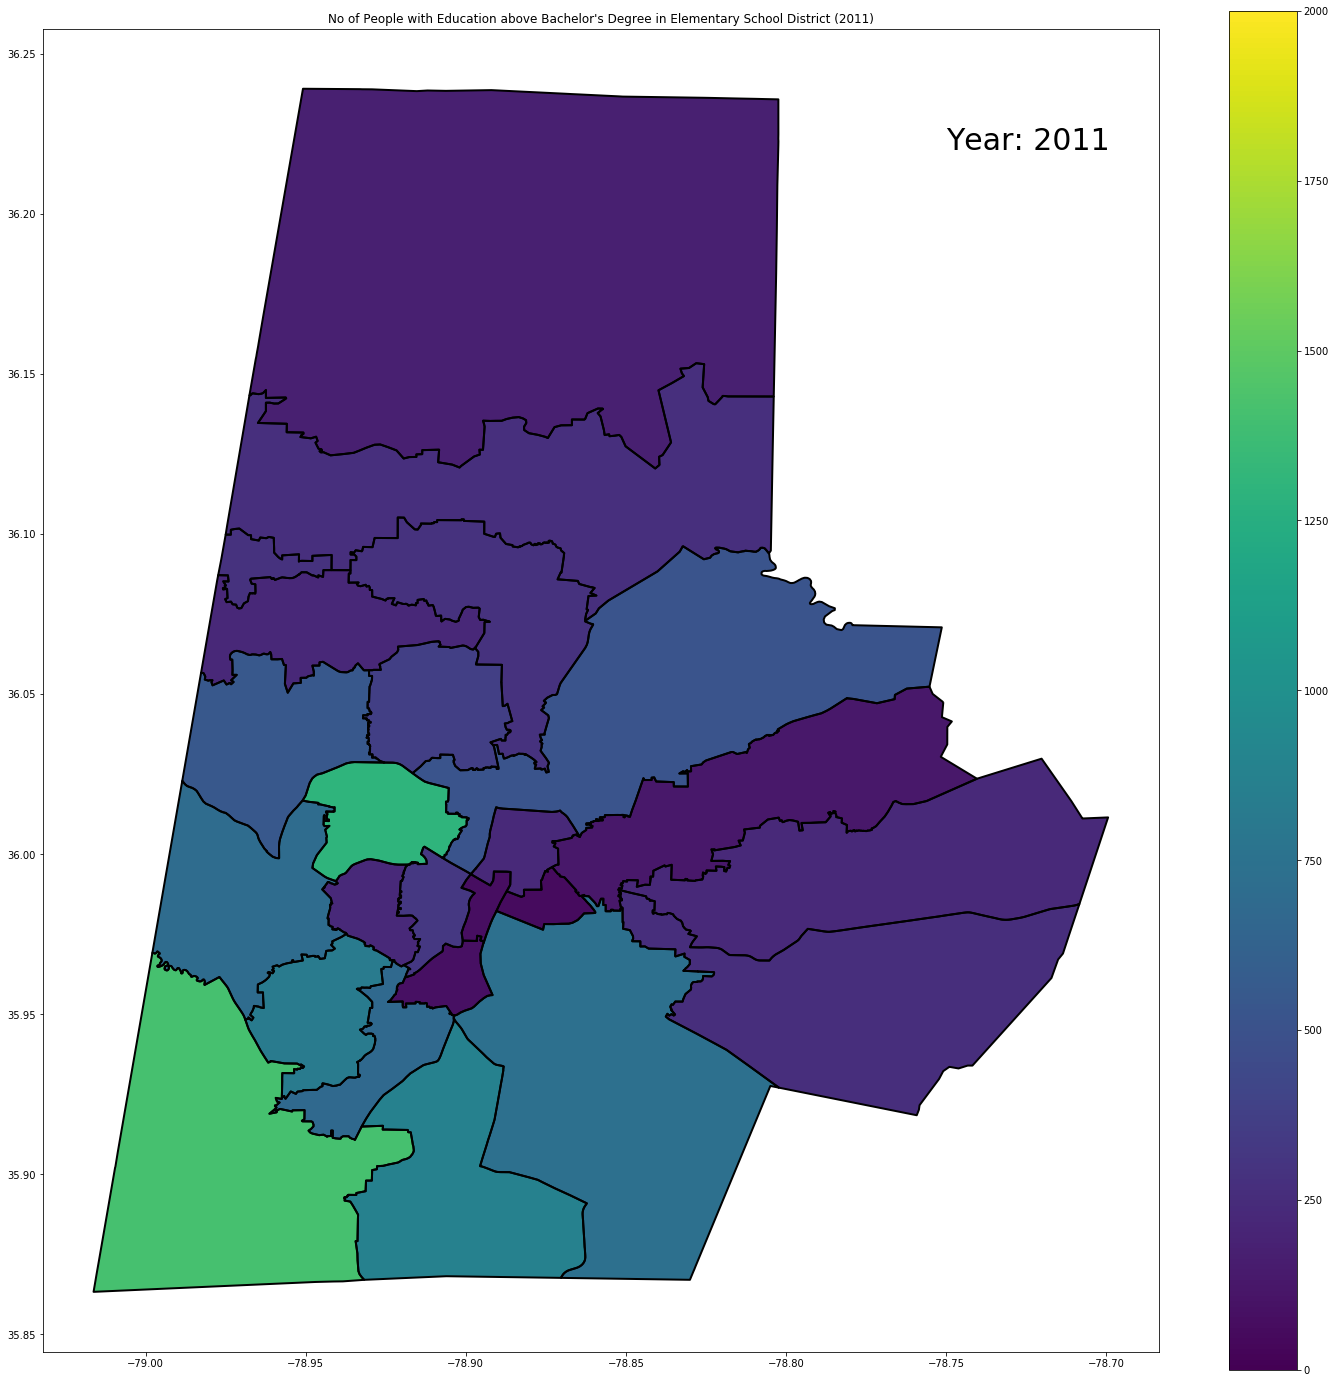

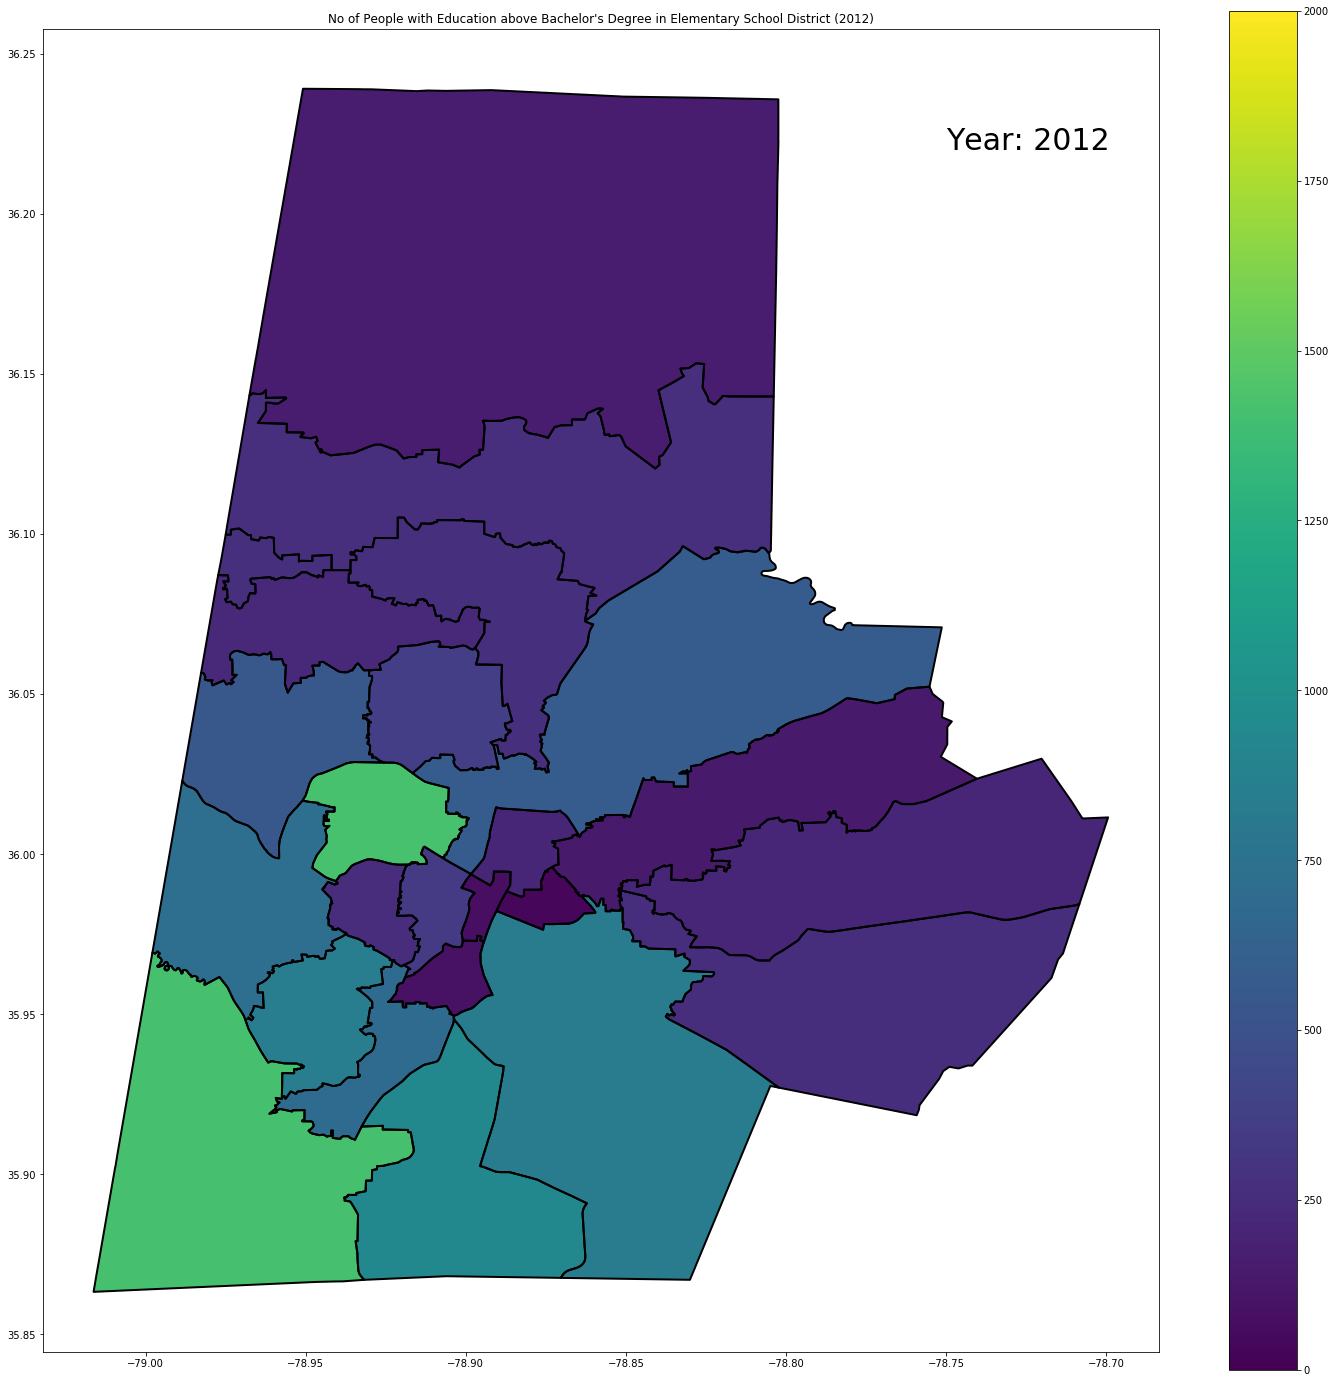

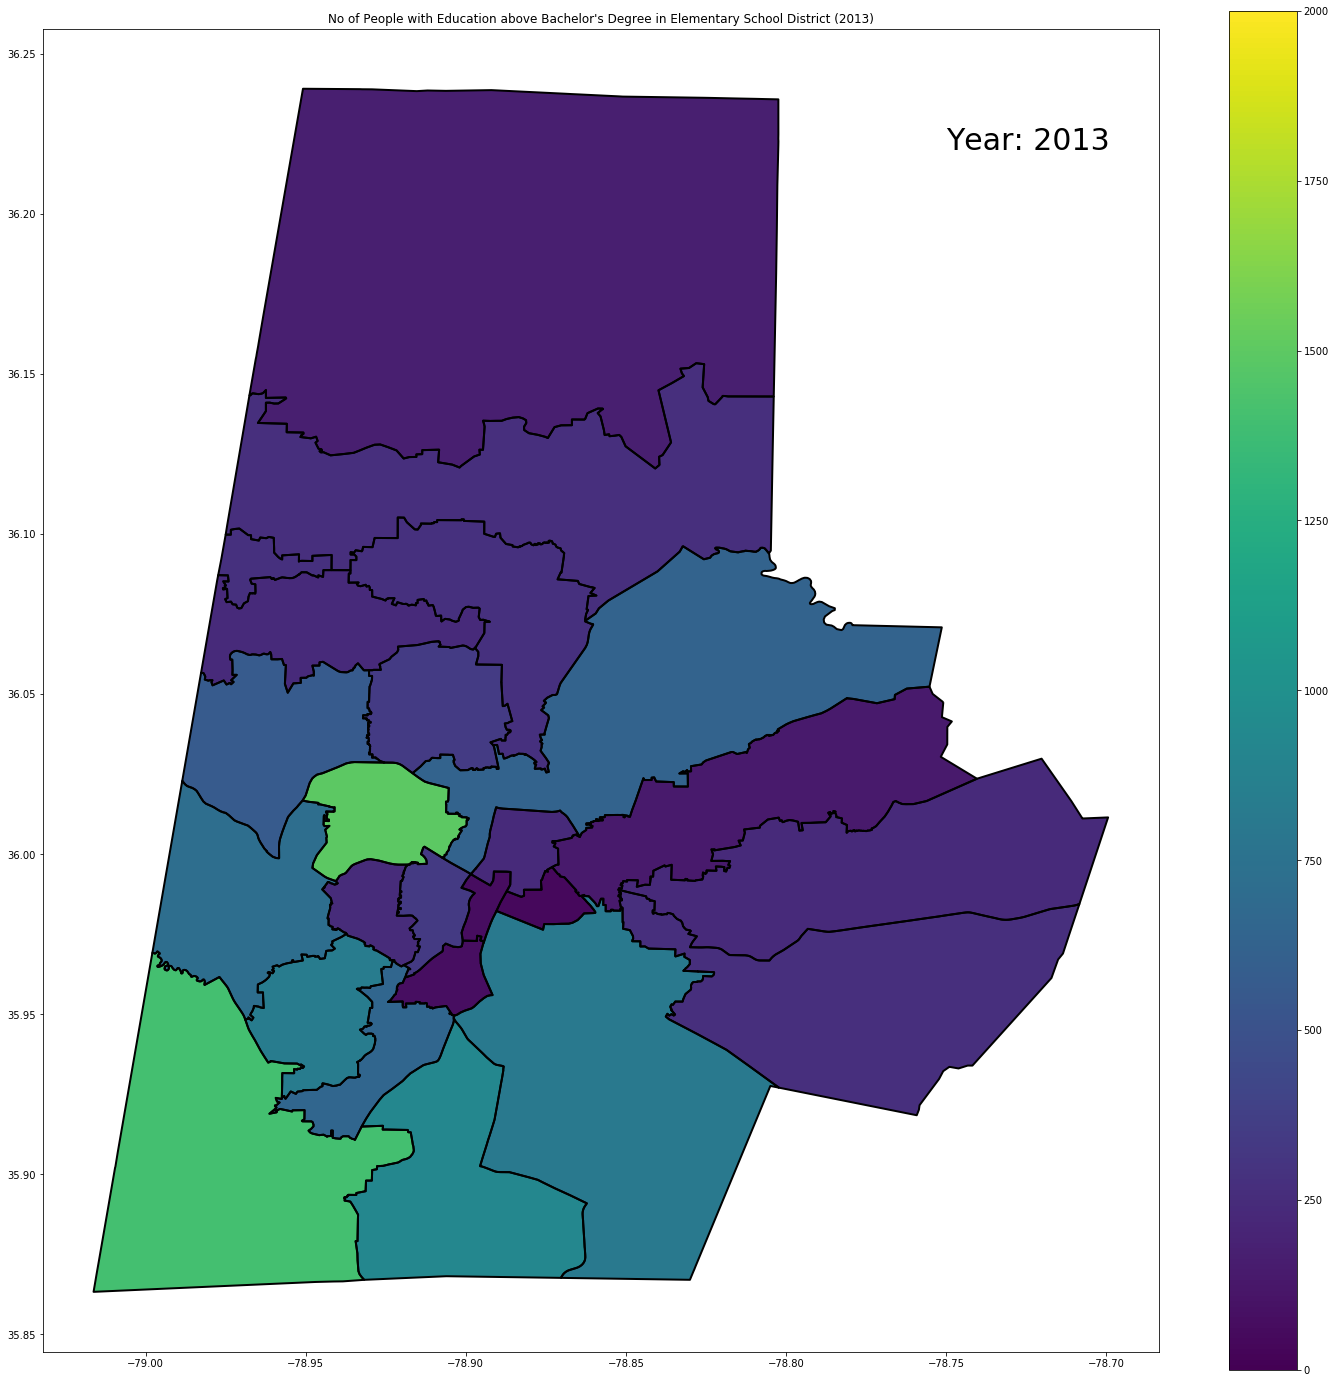

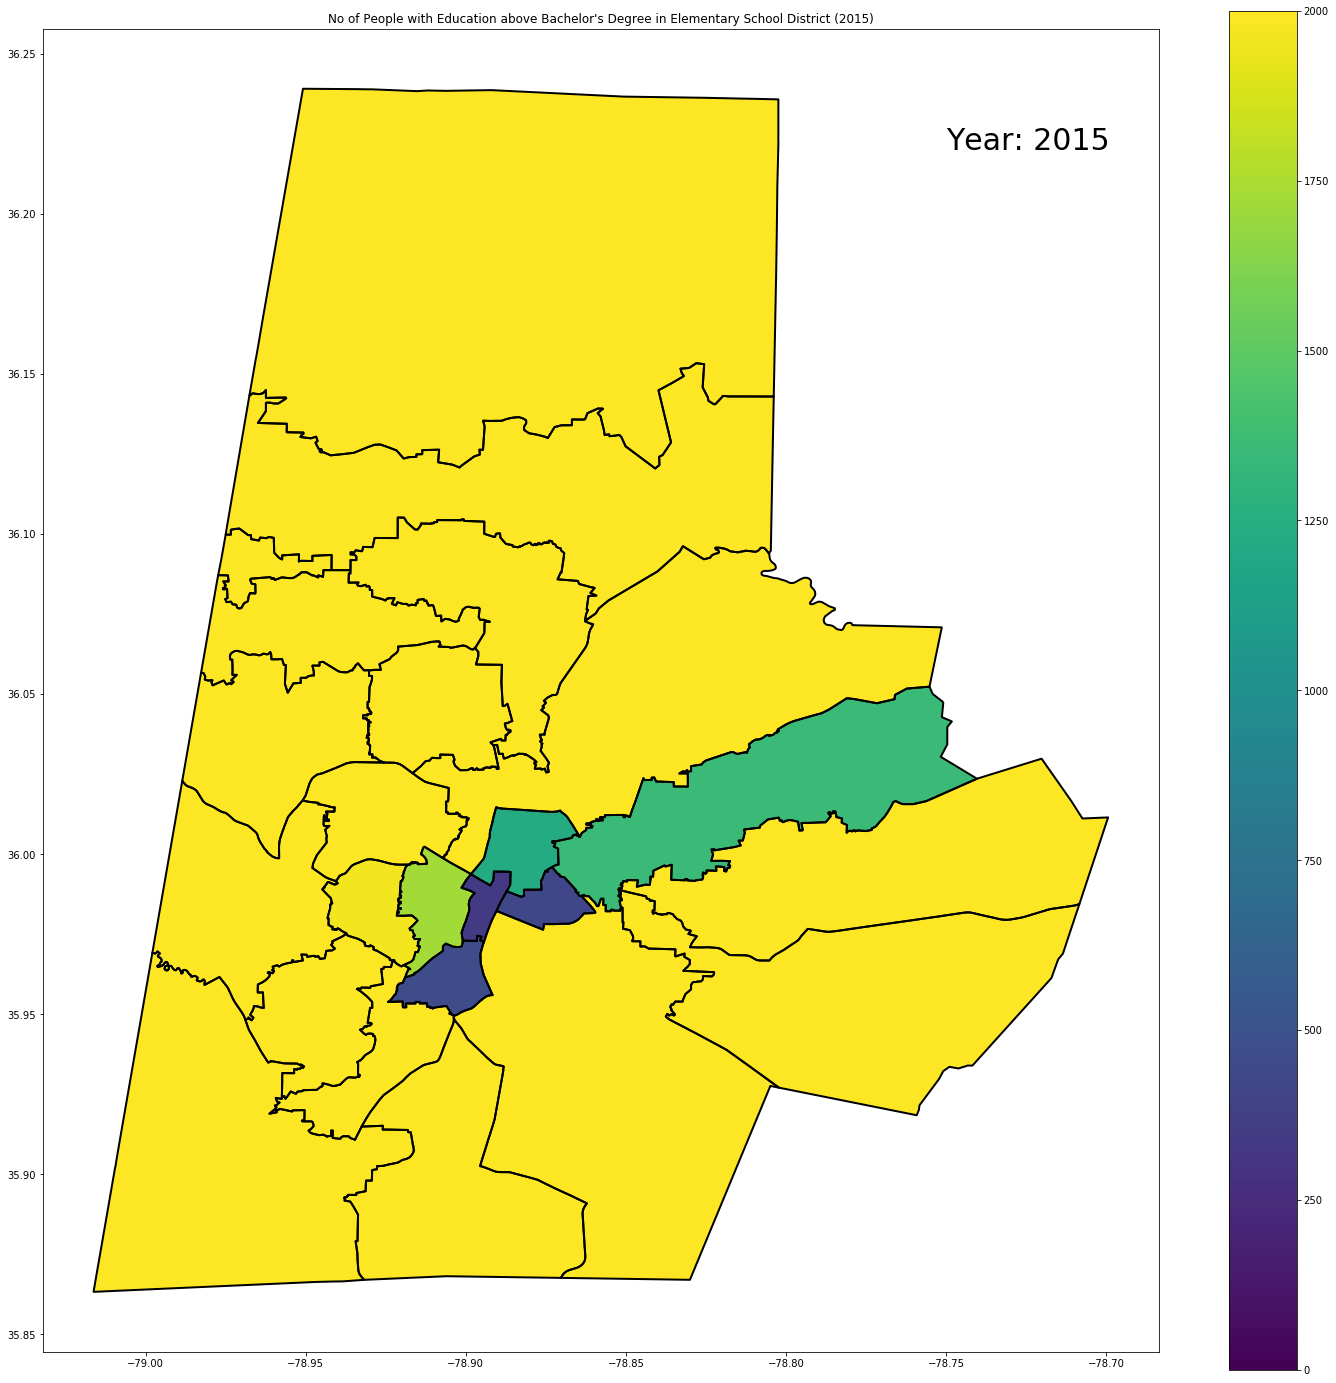

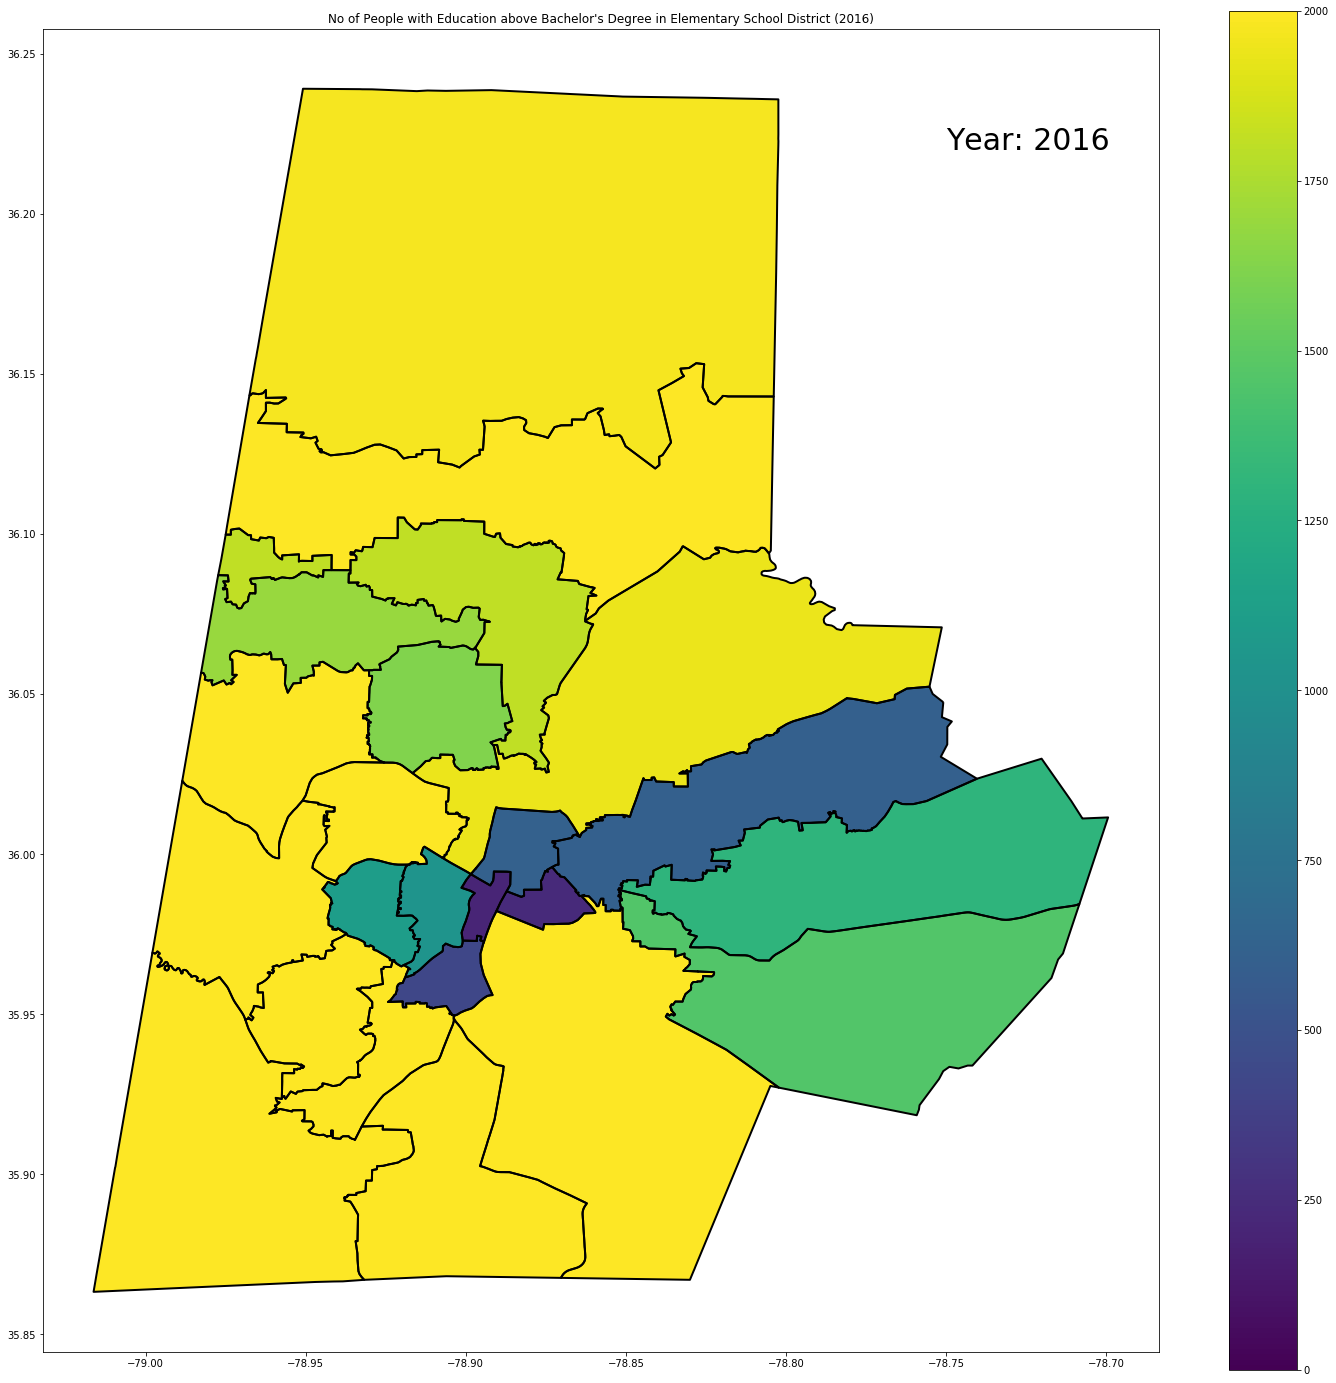

In [135]:
year = 2010
for file_name in file_names:
    tract_nc = gpd.read_file('Shapefile/tl_2019_37_tract/tl_2019_37_tract.shp')
    elem_durham = gpd.read_file("Shapefile/Public_Elementary_School_Base_Assignment_Zones-shp/Public_Elementary_School_Base_Assignment_Zones.shp")
    tract_durham = tract_nc.loc[tract_nc['GEOID'].str.contains('37063')].copy()
    
    file_path = path_name + file_name
    df = pd.read_csv(file_path)
    df = convertHeader(df)

    df_elem = countElemStudents(df)
    tract_durham = tract_durham.merge(df_elem, on='GEOID')
    #Assign School
    assignStuToSchools(tract_durham,elem_durham, eps = 0.001)
    elem_durham['Perc'] = elem_durham['bach_Total']/elem_durham['elem_Total']
    
    ig, ax = plt.subplots(1,1, figsize = (25,25))
    elem_durham.plot(ax = ax, legend = True, column ='bach_Total', alpha = 1, vmin = 0, vmax= 2000)
    elem_durham.geometry.boundary.plot(color = None, edgecolor = 'k', linewidth = 2, ax = ax)

    ax.set_title('No of People with Education above Bachelor\'s Degree in Elementary School District ({})'.format(year))
    ax.text(-78.75, 36.22, 'Year: {}'.format(year), size=30)
    plt.savefig('No_people_above_bachelors_{}.jpg'.format(year), format = 'jpg')
    year +=1

In [22]:
df_compiled.to_csv('df_compiled.csv', index=False)